In [1]:
import os
import numpy as np
import efficientnet.tfkeras
from tensorflow.keras.models import load_model

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]=""

# Select Data

In [3]:
import pandas as pd
df0 = pd.read_csv (r'/home/yupaporn/codes/USAI/detail1_350_.csv')
df01 = df0[(df0['Path Crop']!='None' )&(df0['Path Crop']!='Nan')]
a = df01[df01['Case'].between(1, 10)]
dataframe = a[a['Abs Position']!='P8']
print(dataframe.shape)
print('Normal: ',dataframe[dataframe['Class']=='Normal'].shape)
print('Abnormal: ',dataframe[dataframe['Class']=='Abnormal'].shape)

(405, 8)
Normal:  (115, 8)
Abnormal:  (290, 8)


# load model

In [4]:
model_dir ='/media/tohn/SSD/trainEffbyB/R1/models/B1_R1_imnet.h5'
model = load_model(model_dir)
height = width = model.input_shape[1]

In [5]:
# validation
import pandas as pd
base_dir  = '/media/tohn/SSD/ImageForTrainTest/validation/'
dataframe = pd.read_csv( '/media/tohn/SSD/ImageForTrainTest/validation.csv')
validation_dir = os.path.join(base_dir, 'validation')

#Train
train_df = pd.read_csv( '/media/tohn/SSD/ImageForTrainTest/train.csv')
base_dir0 = '/media/tohn/SSD/ImageForTrainTest/'
os.chdir(base_dir0)
train_dir = os.path.join(base_dir0, 'train')

In [6]:
batch_size = 64
epochs = 10

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
        dataframe = dataframe,
        directory = train_dir,
        x_col = 'Path Crop',
        y_col = 'Class',
        target_size = (height, width),
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical')

#label
labels = (train_generator.class_indices)
labels = dict((v,k.replace("C","")) for k,v in labels.items())
print(labels)

Found 405 validated image filenames belonging to 2 classes.
{0: 'Abnormal', 1: 'Normal'}


# Prediction

In [7]:
from tensorflow.keras.preprocessing import image
def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    val = -1
    idx = -1
    
    return result[0]

#Predict
pred_list = list()
prob_list = list()
img_path=dataframe['Path Crop'].tolist()
for i in range(0,len(img_path)):
    pred_list.append(labels[np.argmax(predict_image(img_path[i]))])
    if np.argmax(predict_image(img_path[i])) == 0:
        prob_list.append(predict_image(img_path[i])[0])
    else:
        prob_list.append(predict_image(img_path[i])[1])
        
#     print(i)
#     print(np.argmax(predict_image(img_path[i])))

dataframe['category'] = pred_list
dataframe['Prob'] = prob_list

In [8]:
dataframe.head(5)

,Unnamed: 0,Unnamed: 0.1,Case,Abs Position,Sub Position,Class,Sub_class,Path Crop,Views,filename,category,Prob
0,0,13,3,P2,P2,Abnormal,AB01,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,AB01 P2 C003.JPG,Normal,0.672025
1,1,15,7,P3,P31,Abnormal,AB01,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-B,AB01 P3-1 C007.JPG,Abnormal,0.865568
2,2,16,5,P2,P2,Abnormal,AB01,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,AB01 P2 C005.JPG,Abnormal,0.856515
3,3,26,9,P5,P51,Abnormal,AB01,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-C,AB01 P5-1 C009.JPG,Abnormal,0.793070
4,4,29,3,P3,P31,Abnormal,AB01,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-B,AB01 P3-1 C003.JPG,Abnormal,0.793409


# Visualization

In [9]:
data_train = dataframe
#เช็คคลาสใน Predicted
pred_class = set(data_train['category'])
print('Predicted : ',len(pred_class))
print(pred_class)
#เช็คคลาสใน Actual
classe = set(data_train['Class'])
print('Actual : ',len(classe))
print(classe)

Predicted :  2
{'Abnormal', 'Normal'}
Actual :  2
{'Abnormal', 'Normal'}


In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix
act = data_train['Class'].array
pred = data_train['category'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 89.62962962962963%
              precision    recall  f1-score   support

    Abnormal       0.95      0.90      0.93       290
      Normal       0.78      0.89      0.83       115

    accuracy                           0.90       405
   macro avg       0.87      0.89      0.88       405
weighted avg       0.90      0.90      0.90       405



### Confusion matrix

Text(0.5, 21.5, 'Predicted label')

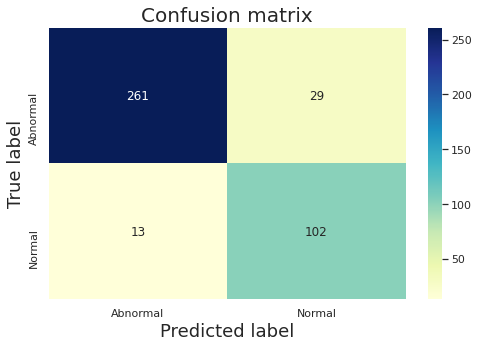

In [11]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

### ROC curve 

#### -  confusion_matrix function 

In [12]:
def confusion_matrix_all(data_train,threshold):

    #1. manage data  --------------------------------------------------------------------------------------------------------------------------------------------------

    p1 = data_train #Input table   
    act= p1['Class'].map({'Normal':0,'Abnormal':1}).values
    pred = p1['category'].map({'Normal':0,'Abnormal':1}).values

    import numpy as np
    n = len(p1)
    proplist = list()
    for i in range(0,n):
        score = p1.iloc[i].to_numpy()
        if score[10]=='Normal':
            prob = 1 - score[11]
            proplist.append(prob)
        else:
            prob = score[11]
            proplist.append(prob)


    prob_all =np.array(proplist)

#2. เงื่อนไข ---------------------------------------------------------------------------------------------------------------------------------------------
    
    import numpy as np
    from sklearn.metrics import confusion_matrix

    TN, FP, FN, TP = confusion_matrix(act, pred).ravel()
    print(TN, FP, FN, TP)

# 3. threshold ----------------------------------------------------------------


    import numpy as np
    from sklearn.metrics import confusion_matrix
    
    t = prob_all >= threshold
    #replace
    ts =t.tolist()
    alist =list()
    for i in range(0,len(ts)):
        if ts[i]==  True:
            a = 1
            alist.append(a)
        else:
            a = 0
            alist.append(a)

    tn, fp, fn, tp = confusion_matrix(act, alist).ravel()

    print('(TN,FP,FN,TP)')
    print('(',tn,',', fp,',', fn,',', tp,')')
    return tn, fp, fn, tp


In [13]:
#Test function
threshold = 0.5
confusion_matrix_all(data_train,threshold)

102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 29 , 261 )


(102, 13, 29, 261)

#### -  run ROC curve

In [14]:
import numpy as np
threshold = np.arange(0.0, 1.002, 0.001)
precision, recall, ACC, TPR, FPR, SPEC = list(),list(),list(),list(),list(),list()
TN0, FP0, FN0, TP0 = list(),list(),list(),list()
for i in threshold:
    precision0, recall0, ACC0, TPR0, FPR0, SPEC0 = list(),list(),list(),list(),list(),list()
    
    tn,fp,fn,tp = confusion_matrix_all(data_train,i) 
    try:
        pre = tp/(tp+fp)
        re= tp/(tp+fn)
        acc = (tp+tn)/(tp+tn+fp+fn)
        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        spec = 1-(tn/(tn+fp))
    except ZeroDivisionError:
        pre,re,acc,tpr,fpr,spec =1,0,0,0,0,0      
            
    TP0.append(tp)
    TN0.append(tn)
    FP0.append(fp)
    FN0.append(fn)
    precision0.append(pre)
    recall0.append(re)
    ACC0.append(acc)
    TPR0.append(re)
    FPR0.append(fpr)       
    SPEC0.append(spec)
        
    precision.append(precision0)
    recall.append(recall0)
    ACC.append(ACC0)
    TPR.append(TPR0)
    FPR.append(FPR0)       
    SPEC.append(SPEC0)

102 13 29 261
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 1 , 114 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 1 , 114 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 1 , 114 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 2 , 113 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 2 , 113 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 2 , 113 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 2 , 113 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 2 , 113 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 2 , 113 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 2 , 113 , 0 , 290 )


102 13 29 261
(TN,FP,FN,TP)
( 62 , 53 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 62 , 53 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 62 , 53 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 62 , 53 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 63 , 52 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 63 , 52 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 63 , 52 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 63 , 52 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 63 , 52 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 64 , 51 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 64 , 51 , 0 , 290 )
102 13 29 261
(TN,FP,FN,TP)
( 64 , 51 , 1 , 289 )
102 13 29 261
(TN,FP,FN,TP)
( 66 , 49 , 1 , 289 )
102 13 29 261
(TN,FP,FN,TP)
( 66 , 49 , 1 , 289 )
102 13 29 261
(TN,FP,FN,TP)
( 66 , 49 , 1 , 289 )
102 13 29 261
(TN,FP,FN,TP)
( 66 , 49 , 3 , 287 )
102 13 29 261
(TN,FP,FN,TP)
( 66 , 49 , 3 , 287 )
102 13 29 261
(TN,FP,FN,TP)
( 66 , 49 , 3 , 287 )
102 13 29 261
(TN,FP,FN,TP)
( 67 , 48 , 3 , 287 )
102 13 29 261
(TN,FP,FN,TP)
( 67 , 48 , 3 , 287 )


102 13 29 261
(TN,FP,FN,TP)
( 89 , 26 , 7 , 283 )
102 13 29 261
(TN,FP,FN,TP)
( 89 , 26 , 7 , 283 )
102 13 29 261
(TN,FP,FN,TP)
( 89 , 26 , 7 , 283 )
102 13 29 261
(TN,FP,FN,TP)
( 89 , 26 , 7 , 283 )
102 13 29 261
(TN,FP,FN,TP)
( 89 , 26 , 7 , 283 )
102 13 29 261
(TN,FP,FN,TP)
( 89 , 26 , 7 , 283 )
102 13 29 261
(TN,FP,FN,TP)
( 89 , 26 , 7 , 283 )
102 13 29 261
(TN,FP,FN,TP)
( 89 , 26 , 7 , 283 )
102 13 29 261
(TN,FP,FN,TP)
( 89 , 26 , 7 , 283 )
102 13 29 261
(TN,FP,FN,TP)
( 89 , 26 , 8 , 282 )
102 13 29 261
(TN,FP,FN,TP)
( 89 , 26 , 8 , 282 )
102 13 29 261
(TN,FP,FN,TP)
( 89 , 26 , 8 , 282 )
102 13 29 261
(TN,FP,FN,TP)
( 89 , 26 , 9 , 281 )
102 13 29 261
(TN,FP,FN,TP)
( 90 , 25 , 9 , 281 )
102 13 29 261
(TN,FP,FN,TP)
( 90 , 25 , 9 , 281 )
102 13 29 261
(TN,FP,FN,TP)
( 90 , 25 , 9 , 281 )
102 13 29 261
(TN,FP,FN,TP)
( 90 , 25 , 9 , 281 )
102 13 29 261
(TN,FP,FN,TP)
( 90 , 25 , 9 , 281 )
102 13 29 261
(TN,FP,FN,TP)
( 90 , 25 , 9 , 281 )
102 13 29 261
(TN,FP,FN,TP)
( 90 , 25 , 9 , 281 )


102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 26 , 264 )
102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 26 , 264 )
102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 27 , 263 )
102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 27 , 263 )
102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 27 , 263 )
102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 27 , 263 )
102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 27 , 263 )
102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 28 , 262 )
102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 28 , 262 )
102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 29 , 261 )
102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 29 , 261 )
102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 29 , 261 )
102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 29 , 261 )
102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 29 , 261 )
102 13 29 261
(TN,FP,FN,TP)
( 102 , 13 , 29 , 261 )
102 13 29 261
(TN,FP,FN,TP)
( 103 , 12 , 29 , 261 )
102 13 29 261
(TN,FP,FN,TP)
( 103 , 12 , 29 , 261 )
102 13 29 261
(TN,FP,FN,TP)
( 103 , 12 , 30 , 260 )
102 13 29 261
(TN,FP,FN,TP)
( 103 , 12 , 30 , 260 )
102 13 29 26

102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 69 , 221 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 69 , 221 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 69 , 221 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 70 , 220 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 70 , 220 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 70 , 220 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 71 , 219 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 71 , 219 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 72 , 218 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 72 , 218 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 72 , 218 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 73 , 217 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 74 , 216 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 74 , 216 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 74 , 216 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 75 , 215 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 76 , 214 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 76 , 214 )
102 13 29 261
(TN,FP,FN,TP)
( 109 , 6 , 76 , 214 )
102 13 29 261
(TN,FP,FN,TP)
( 1

102 13 29 261
(TN,FP,FN,TP)
( 114 , 1 , 180 , 110 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 181 , 109 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 182 , 108 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 184 , 106 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 185 , 105 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 185 , 105 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 185 , 105 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 187 , 103 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 187 , 103 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 189 , 101 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 189 , 101 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 189 , 101 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 190 , 100 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 190 , 100 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 190 , 100 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 190 , 100 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 190 , 100 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 190 , 100 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 191 , 99 )
102 13 29 261

102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )


/home/yupaporn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
102 13 29 261
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )


In [15]:
#average per threshold 
precision1,recall1,ACC1,TPR1,FPR1,SPEC1 = list(),list(),list(),list(),list(),list()
from statistics import *
for m in range(0,len(precision)):
    a1 =mean(precision[m])
    a2 =mean(recall[m])
    a3 =mean(ACC[m])
    a4 =mean(TPR[m])
    a5 =mean(FPR[m])
    a6 =mean(SPEC[m])
    
    precision1.append(a1)
    recall1.append(a2)
    ACC1.append(a3)
    TPR1.append(a4)
    FPR1.append(a5)       
    SPEC1.append(a6)   

In [16]:
#create dataframe
import numpy as np
i = np.arange(len(precision1)) # index for df
roc0 = pd.DataFrame({'Threshold' : pd.Series(threshold, index=i),'Precision' : pd.Series(precision1, index = i),'Recall' : pd.Series(recall1, index = i),
                     'tpr' : pd.Series(TPR1, index = i),'fpr' : pd.Series(FPR1, index = i),'1-Spec' : pd.Series(SPEC1, index = i),  'ACC' : pd.Series(ACC1, index = i), 
                     'TN' : pd.Series(TN0, index = i), 'FP' : pd.Series(FP0, index = i), 'FN' : pd.Series(FN0, index = i), 'TP' : pd.Series(TP0, index = i)},)
roc0 = roc0.fillna(1)

In [17]:
roc0.head(10)

,Threshold,Precision,Recall,tpr,fpr,1-Spec,ACC,TN,FP,FN,TP
0,0.000,0.716049,1.0,1.0,1.0,1.0,0.716049,0,115,0,290
1,0.001,0.716049,1.0,1.0,1.0,1.0,0.716049,0,115,0,290
2,0.002,0.716049,1.0,1.0,1.0,1.0,0.716049,0,115,0,290
3,0.003,0.716049,1.0,1.0,1.0,1.0,0.716049,0,115,0,290
4,0.004,0.716049,1.0,1.0,1.0,1.0,0.716049,0,115,0,290
5,0.005,0.716049,1.0,1.0,1.0,1.0,0.716049,0,115,0,290
6,0.006,0.716049,1.0,1.0,1.0,1.0,0.716049,0,115,0,290
7,0.007,0.716049,1.0,1.0,1.0,1.0,0.716049,0,115,0,290
8,0.008,0.716049,1.0,1.0,1.0,1.0,0.716049,0,115,0,290
9,0.009,0.716049,1.0,1.0,1.0,1.0,0.716049,0,115,0,290


#### -  sen VS spec

No handles with labels found to put in legend.


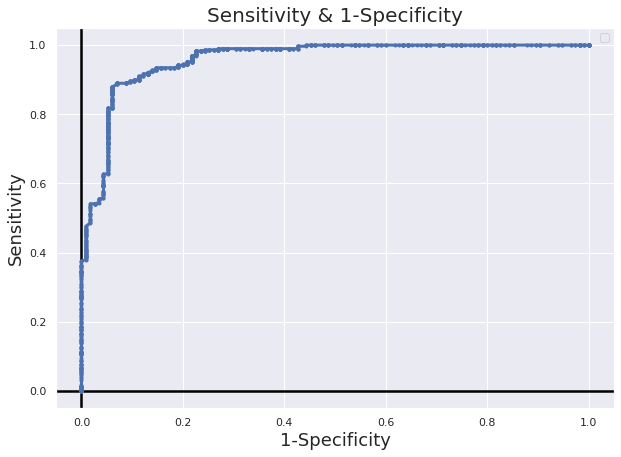

PR AUC (area = 0.96)


In [18]:
#sen VS spec
import numpy as np
import matplotlib.pyplot as plt
sen= np.array(roc0['tpr'])
spec = np.array(roc0['1-Spec'])
# from matplotlib import pyplot
lw = 3
fig, ax = plt.subplots(figsize=(10, 7))
plt.axhline(0, lw=2.5, color='black')
plt.axvline(0, lw=2.5, color='black')
plt.plot([0, 0],[1, 1],'c', linestyle='--',lw=2.5)
plt.plot(spec,sen,'b', marker='.',lw=lw)  
    # axis labels
plt.xlabel('1-Specificity',fontsize=18)
plt.ylabel('Sensitivity',fontsize=18)
plt.title('Sensitivity & 1-Specificity',fontsize=20)
    # show the legend
plt.legend()
    # show the plot
plt.show()
    # calculate the precision-recall auc
from sklearn.metrics import auc
auc_score = auc(spec, sen)
print('PR AUC (area = %0.2f)' % (auc_score))

#### -  Precision & Recall Curve

No handles with labels found to put in legend.


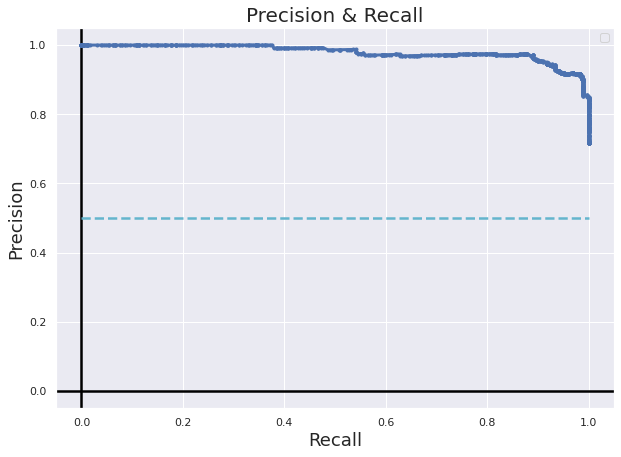

PR AUC (area = 0.98)


In [19]:
#Precision & Recall Curve
import numpy as np
recall = np.array(roc0['Recall'])
precision = np.array(roc0['Precision'])

import matplotlib.pyplot as plt
from matplotlib import pyplot
lw = 3
fig, ax = plt.subplots(figsize=(10, 7))
plt.axhline(0, lw=2.5, color='black')
plt.axvline(0, lw=2.5, color='black')
fig.patch.set_facecolor('w')
plt.plot([0, 1], [0.5, 0.5],'c', linestyle='--',lw=2.5)
pyplot.plot(recall, precision,'b', marker='.', lw=lw)
    # axis labels
pyplot.xlabel('Recall',fontsize=18)
pyplot.ylabel('Precision',fontsize=18)
pyplot.title('Precision & Recall',fontsize=20)
    # show the legend
pyplot.legend()
    # show the plot
pyplot.show()
    # calculate the precision-recall auc
from sklearn.metrics import auc
auc_score = auc(recall, precision)
print('PR AUC (area = %0.2f)' % (auc_score))

# Grad CAM

### - create dataframe for Grad CAM 

In [20]:
#สร้าง folder เก็บรูป 
import os
import shutil

path0 = "/media/tohn/SSD/image/test_GradCam/B1_val" 

try:
    os.mkdir(path0)
except OSError:
    shutil.rmtree(path0)
    os.mkdir(path0)

In [21]:
#สร้าง folder เก็บรูป 
import os
import shutil

path1 = path0+'/abn_correct/'
path2 = path0+'/abn_missing/'
path3 = path0+'/Nor_correct/'
path4 = path0+'/Nor_missing/'
try:
    os.mkdir(path1)
    os.mkdir(path2)
    os.mkdir(path3)
    os.mkdir(path4)
except OSError:
    shutil.rmtree(path1)
    shutil.rmtree(path2)
    shutil.rmtree(path3)
    shutil.rmtree(path4)
    os.mkdir(path1)
    os.mkdir(path2)
    os.mkdir(path3)
    os.mkdir(path4)

### - Abnormal 

In [22]:
#load image function
def load_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    return x,img

In [23]:
df = dataframe
abnormal  = df[df['Class']=='Abnormal']
ab_correct = abnormal[abnormal['Class']==abnormal['category']] # correct
ab_wrong = abnormal[abnormal['Class']!=abnormal['category']]
#select position 
print('abnormal:',len(abnormal))
print('ab_correct:',len(ab_correct))
print('ab_wrong:',len(ab_wrong))
print(len(set(ab_correct['Sub Position'])))
print(set(ab_correct['Sub Position']))

abnormal: 290
ab_correct: 261
ab_wrong: 29
11
{'P51', 'P41', 'P31', 'P72', 'P42', 'P52', 'P2', 'P1', 'P61', 'P62', 'P71'}


####  ab_correct 

##### TF-explain 

In [24]:
#### load only max &min prob of each views(P1,P2,P31,...,P72) *** For correct
max_df = list()
min_df = list()
classs = list(set(ab_correct['Sub Position']))
for i in classs:
    posi = ab_correct[ab_correct['Sub Position'] == i]
    #max
    max_prob = posi[posi['Prob'] == posi['Prob'].max()][0:1].reset_index()
    SubPosi = i
    case = 'ab_correct'
    case_prob = 'Max'
    prob = max_prob['Prob'].tolist()[0]
    path = max_prob['Path Crop'].tolist()[0]

    max_df.append({'Sub Position':SubPosi,'Case':case,'Case_prob':case_prob,'Prob':prob,'Path':path})
    
    #min
    min_prob = posi[posi['Prob'] == posi['Prob'].min()][0:1].reset_index()
    SubPosi = i
    case = 'ab_correct'
    case_prob = 'Min'
    prob = min_prob['Prob'].tolist()[0]
    path = min_prob['Path Crop'].tolist()[0]

    min_df.append({'Sub Position':SubPosi,'Case':case,'Case_prob':case_prob,'Prob':prob,'Path':path})
tabktdf = pd.DataFrame(max_df+min_df)
tabktdf

,Sub Position,Case,Case_prob,Prob,Path
0,P51,ab_correct,Max,0.941443,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...
1,P41,ab_correct,Max,0.943320,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...
2,P31,ab_correct,Max,0.943824,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...
3,P72,ab_correct,Max,0.866244,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...
4,P42,ab_correct,Max,0.969776,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...
5,P52,ab_correct,Max,0.955517,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...
6,P2,ab_correct,Max,0.944008,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...
7,P1,ab_correct,Max,0.946297,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...
8,P61,ab_correct,Max,0.907034,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...
9,P62,ab_correct,Max,0.905729,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...


In [25]:
img_paths = tabktdf['Path'].tolist()
case = tabktdf['Case_prob'].tolist()
prob = tabktdf['Prob'].round(4).tolist()
imlist = list()
idx = range(0,len(img_paths))
for i in idx :
    j = img_paths[i]
    imlist.append(j)
    j = j.split('/')[-1]
    os.chdir(path1)
    import cv2
    from matplotlib import pyplot as plt
    from tf_explain.core.grad_cam import GradCAM
    explainer = GradCAM()

    img,ori = load_image(img_paths[i])
    data = (img, None)

    grid = explainer.explain(data, model, class_index=0)
    
    explainer.save(grid,'.',"ab_cor_"+str(i)+"_"+str(case[i])+"_"+str(prob[i])+"_"+str(j)+".png")
print(len(imlist))

22


##### Load USAI image 

In [26]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
# load the image
idx = imlist
for i in idx :
    j = i
    j = j.split('/')[-1]
    img = image.load_img(i)
    os.chdir(path1)
    save_img(str(j)+'.png', img)
print(len(imlist))

Using TensorFlow backend.


22


####  ab_wrong

In [27]:
print('nor_wrong:',len(ab_wrong))
w_img_paths = ab_wrong['Path Crop'].tolist()
w_prob = ab_wrong['Prob'].round(4).tolist()
ab_wrong.shape

nor_wrong: 29


(29, 12)

In [28]:
imlist = list()
idx = range(0,len(w_img_paths))
for i in idx :
    j = w_img_paths[i]
    imlist.append(j)
    j = j.split('/')[-1]
#     print(j)
    os.chdir(path2)
    import cv2
    from matplotlib import pyplot as plt
    from tf_explain.core.grad_cam import GradCAM
    explainer = GradCAM()

    img,ori = load_image(w_img_paths[i])
    data = (img, None)

    grid = explainer.explain(data, model, class_index=0) 
    explainer.save(grid,'.',"Nor_missing_"+str(w_prob[i])+"_"+str(j)+"_"+str(i)+".png")
print(len(imlist))

29


#####  Load USAI image

In [29]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
idx = imlist
for i in idx :
    j = i
    j = j.split('/')[-1]
    img = image.load_img(i)
    os.chdir(path2)
    save_img(str(j)+'.png', img)
print(len(imlist))

29


#### *Show Correct Abnormal GradCam*

/media/tohn/HDD/VISION_dataset/USAI/ABnormal01/1 ABNORMAL/cropped/AB01 P5-1 C007.JPG


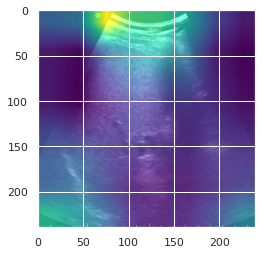

In [30]:
from tf_explain.core.grad_cam import GradCAM
explainer = GradCAM()
img,ori = load_image(img_paths[0])
data = (img, None)
grid = explainer.explain(data, model, class_index=1) 
explainer.save(grid, ".", "grad_cam.png")
print(img_paths[0])
plt.imshow(grid)

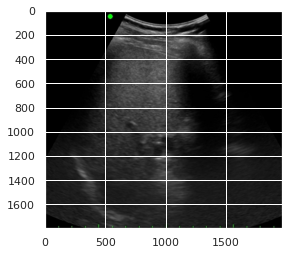

In [31]:
import matplotlib.image as mpimg
img = mpimg.imread(img_paths[0])
plt.imshow(img)

#### *Show Miss Abnormal GradCam*

/media/tohn/HDD/VISION_dataset/USAI/ABnormal01/1 ABNORMAL/cropped/AB01 P5-1 C007.JPG


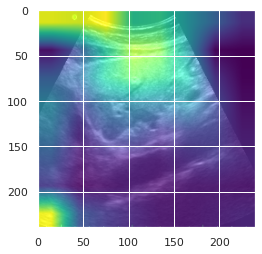

In [32]:
from tf_explain.core.grad_cam import GradCAM
explainer = GradCAM()
img,ori = load_image(w_img_paths[0])
data = (img, None)
grid = explainer.explain(data, model, class_index=1) 
explainer.save(grid, ".", "grad_cam.png")
print(img_paths[0])
plt.imshow(grid)

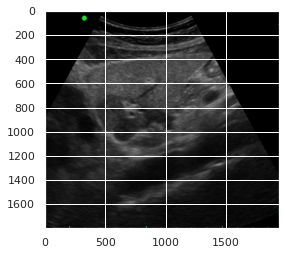

In [33]:
import matplotlib.image as mpimg
img = mpimg.imread(w_img_paths[0])
plt.imshow(img)

### Normal

In [34]:
df = dataframe
normal  = df[df['Class']=='Normal']
nor_correct = normal[normal['Class']==normal['category']] # correct
nor_wrong = normal[normal['Class']!=normal['category']]
print('normal:',len(normal))
print('nor_correct:',len(nor_correct))
print('nor_wrong:',len(nor_wrong))
#select position 
print(len(set(nor_correct['Sub Position'])))
print(set(nor_correct['Sub Position']))

normal: 115
nor_correct: 102
nor_wrong: 13
12
{'P41', 'P51', 'P31', 'P72', 'P42', 'P52', 'P2', 'P1', 'P61', 'P32', 'P62', 'P71'}


#### nor_correct 

##### TF-explain

In [35]:
#### load only max &min prob of each views(P1,P2,P31,...,P72) *** For correct
max_df = list()
min_df = list()
classs = list(set(nor_correct['Sub Position']))
for i in classs:
    posi = nor_correct[nor_correct['Sub Position'] == i]
    #max
    max_prob = posi[posi['Prob'] == posi['Prob'].max()][0:1].reset_index()
    SubPosi = i
    case = 'nor_correct'
    case_prob = 'Max'
    prob = max_prob['Prob'].tolist()[0]
    path = max_prob['Path Crop'].tolist()[0]

    max_df.append({'Sub Position':SubPosi,'Case':case,'Case_prob':case_prob,'Prob':prob,'Path':path})
    
    #min
    min_prob = posi[posi['Prob'] == posi['Prob'].min()][0:1].reset_index()
    SubPosi = i
    case = 'nor_correct'
    case_prob = 'Min'
    prob = min_prob['Prob'].tolist()[0]
    path = min_prob['Path Crop'].tolist()[0]

    min_df.append({'Sub Position':SubPosi,'Case':case,'Case_prob':case_prob,'Prob':prob,'Path':path})
tabktdf = pd.DataFrame(max_df+min_df)
tabktdf

,Sub Position,Case,Case_prob,Prob,Path
0,P41,nor_correct,Max,0.990074,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
1,P51,nor_correct,Max,0.977773,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
2,P31,nor_correct,Max,0.979318,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
3,P72,nor_correct,Max,0.957400,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
4,P42,nor_correct,Max,0.987315,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
5,P52,nor_correct,Max,0.969509,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
6,P2,nor_correct,Max,0.965804,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
7,P1,nor_correct,Max,0.969570,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
8,P61,nor_correct,Max,0.954264,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
9,P32,nor_correct,Max,0.866419,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...


In [36]:
#Load Grad Cam image

img_paths = tabktdf['Path'].tolist()
case = tabktdf['Case_prob'].tolist()
prob = tabktdf['Prob'].round(4).tolist()

imlist = list()
idx = range(0,len(img_paths))
for i in idx :
    j = img_paths[i]
    imlist.append(j)
    j = j.split('/')[-1]
    os.chdir(path3)
    import cv2
    from matplotlib import pyplot as plt
    from tf_explain.core.grad_cam import GradCAM
    explainer = GradCAM()

    img,ori = load_image(img_paths[i])
    data = (img, None)

    grid = explainer.explain(data, model, class_index=0) 
    explainer.save(grid,'.',"nor_cor_"+str(i)+"_"+str(case[i])+"_"+str(prob[i])+"_"+str(j)+".png")
print(len(imlist))

24


#####  Load USAI image

In [37]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
# load the image
idx = imlist
for i in idx :
    j = i
    j = j.split('/')[-1]
    img = image.load_img(i)
    os.chdir(path3)
    save_img(str(j)+'.png', img)
print(len(imlist))

24


#### Normal Miss

In [38]:
print('nor_wrong:',len(nor_wrong))

nor_wrong: 13


In [39]:
w_img_paths = nor_wrong['Path Crop'].tolist()
w_prob = nor_wrong['Prob'].round(4).tolist()
nor_wrong.shape

(13, 12)

In [40]:
imlist = list()
idx = range(0,len(w_img_paths))
for i in idx :
    j = w_img_paths[i]
    imlist.append(j)
    j = j.split('/')[-1]
#     print(j)
    os.chdir(path4)
    import cv2
    from matplotlib import pyplot as plt
    from tf_explain.core.grad_cam import GradCAM
    explainer = GradCAM()

    img,ori = load_image(w_img_paths[i])
    data = (img, None)

    grid = explainer.explain(data, model, class_index=0) 
    explainer.save(grid,'.',"Nor_missing_"+str(w_prob[i])+"_"+str(j)+"_"+str(i)+".png")
print(len(imlist))

13


##### Load USAI image 

In [41]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
idx = imlist
for i in idx :
    j = i
    j = j.split('/')[-1]
    img = image.load_img(i)
    os.chdir(path4)
    save_img(str(j)+'.png', img)
print(len(imlist))

13


##### *Show Correct NormalGradCam*

/media/tohn/HDD/VISION_dataset/USAI/Prelim. Imgs/P4/Test/cropped/P4_Case_008-1.jpg


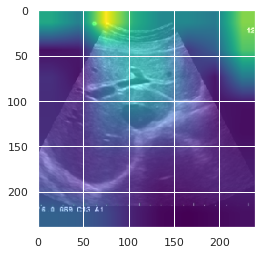

In [42]:
from tf_explain.core.grad_cam import GradCAM
explainer = GradCAM()
img,ori = load_image(img_paths[0])
data = (img, None)
grid = explainer.explain(data, model, class_index=1) 
explainer.save(grid, ".", "grad_cam.png")
print(img_paths[0])
plt.imshow(grid)

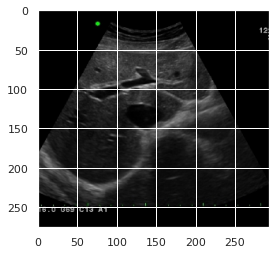

In [43]:
img = mpimg.imread(img_paths[0])
plt.imshow(img)

##### *Show Miss Normal GradCam*

/media/tohn/HDD/VISION_dataset/USAI/Prelim. Imgs/P4/Test/cropped/P4_Case_008-1.jpg


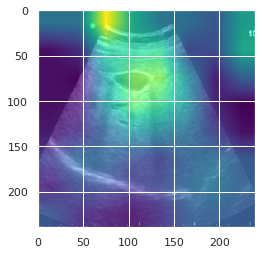

In [44]:
from tf_explain.core.grad_cam import GradCAM
explainer = GradCAM()
img,ori = load_image(w_img_paths[0])
data = (img, None)
grid = explainer.explain(data, model, class_index=1) 
explainer.save(grid, ".", "grad_cam.png")
print(img_paths[0])
plt.imshow(grid)

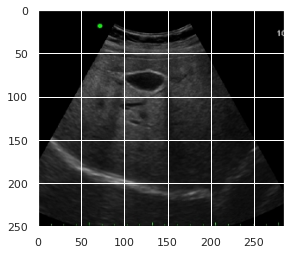

In [45]:
img = mpimg.imread(w_img_paths[0])
plt.imshow(img)